# Timeseries by region - all variables!
- Plot regional timeseries by decade
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- July 2025

In [218]:
import utils
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
from matplotlib import colors as c
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

In [6]:
# save tarea and convert to km2
cm2_to_km2 = 100.0 * 100.0 * 1000.0 * 1000.0
tarea = ds_grid.TAREA/cm2_to_km2

## Regions

### Load regional masks
- WS = Weddell Sea
- PB = East Antarctic - Prydz Bay
- DU = East Antarctic - D'Urville
- RS = Ross Sea
- AS = Amundsen Sea
- AP = Antarctic Peninsula

Get these from both the CCAMLR mask file and the story regions

In [7]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [8]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

In [9]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [10]:
# Read in "story regions"
file_in = 'antarctic_polygons/antarctic_polygon_areas_v3.nc'
ds_stories= xr.open_mfdataset(dir_in+file_in,decode_times=False)

In [11]:
# make region_list
region_list = ['Weddell', 'Prydz', 'DUrville', 'Ross', 'Amundsen', 'Peninsula']

In [12]:
# keep masks for regions of interest
WS_region = ds_ccamlr.mpa_plan_3
PB_region = ds_stories.story_prydz
DU_region = ds_stories.story_durville
RS_region = ds_stories.story_ross
AS_region = ds_stories.story_amundsen
AP_region = ds_ccamlr.mpa_plan_1

In [13]:
# concatenate into a single mask array for easier use

region_masks = xr.concat([WS_region, PB_region, DU_region,
                          RS_region, AS_region, AP_region],
                         dim='region')
region_masks['region'] = region_list

In [14]:
# get tarea for each region (needed below for regional averages)
tarea_region = region_masks * tarea

### Load shapefiles

In [15]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [16]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

### Quick plot of the regions

In [17]:
# get data to plot
data_plt = region_masks.fillna(0)

# get lats/lons
lons = ds_stories.TLONG
lats = ds_stories.TLAT

In [18]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [19]:
# set contour levels
levels_in_ctr = np.arange(0,3,1)

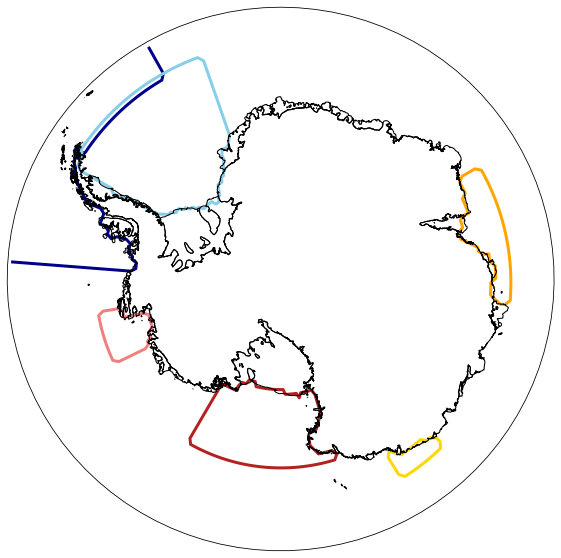

In [20]:
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot regions
reg = 'Peninsula'
color = 'darkblue'
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_plt.sel(region=reg))
this1=ax.contour(lon,lat,field,
                 colors=color,linestyles='solid',linewidths=3,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
reg = 'Weddell'
color = 'skyblue'
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_plt.sel(region=reg))
this1=ax.contour(lon,lat,field,
                 colors=color,linestyles='solid',linewidths=3,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
reg = 'Prydz'
color = 'orange'
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_plt.sel(region=reg))
this1=ax.contour(lon,lat,field,
                 colors=color,linestyles='solid',linewidths=3,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
reg = 'DUrville'
color = 'gold'
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_plt.sel(region=reg))
this1=ax.contour(lon,lat,field,
                 colors=color,linestyles='solid',linewidths=3,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
reg = 'Ross'
color = 'firebrick'
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_plt.sel(region=reg))
this1=ax.contour(lon,lat,field,
                 colors=color,linestyles='solid',linewidths=3,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
reg = 'Amundsen'
color = 'lightcoral'
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_plt.sel(region=reg))
this1=ax.contour(lon,lat,field,
                 colors=color,linestyles='solid',linewidths=3,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=100)

## Load the data - ALL variables

- Mask them as needed for habitat suitability, etc.
- Calculate regional area weighted averages for each year and ensemble member, if needed. Note that penguin data does not need this because the data was a projection done for that region specifically

### Load the SIC data

In [21]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'

In [22]:
# Read in cesm2-le  data
file_in = 'CESM2-LE-SIC_OND.nc'
ds_in = xr.open_mfdataset(dir_in+file_in,decode_times=False)

ds_in

# reassign nlat and nlon for later
ds_in['nlat'] = ds_grid.nlat
ds_in['nlon'] = ds_grid.nlon

In [23]:
# keep the variable of interest only
sic = ds_in.SIC_OND

# multiply by 100 to get in concentration
sic = sic * 100.0

In [24]:
# calculate regional average

# multiply data by tarea and regions to get just regions of interest in each variable
sic_regions = sic * region_masks * tarea

# calculate area weighted averages of each variable for each region
sic_avg = sic_regions.sum(dim=['nlat','nlon'])/tarea_region.sum(dim=['nlat','nlon'])

### Load the SST data

In [25]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'

In [26]:
# Read in cesm2-le  data
file_in = 'CESM2-LE-summer-mean-SST.nc'
ds_in = xr.open_mfdataset(dir_in+file_in,decode_times=False)

ds_in

# reassign nlat and nlon for later
ds_in['nlat'] = ds_grid.nlat
ds_in['nlon'] = ds_grid.nlon

In [27]:
# keep the variable of interest only
sst = ds_in.SST_MAR

In [28]:
# calculate regional average

# multiply data by tarea and regions to get just regions of interest in each variable
sst_regions = sst * region_masks * tarea

# calculate area weighted averages of each variable for each region
sst_avg = sst_regions.sum(dim=['nlat','nlon'])/tarea_region.sum(dim=['nlat','nlon'])

### Load the TBOT data

In [29]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'

In [30]:
# Read in cesm2-le  data
file_in = 'CESM2-LE-annual-mean-TBOT.nc'
ds_in = xr.open_mfdataset(dir_in+file_in,decode_times=False)

ds_in

# reassign nlat and nlon for later
ds_in['nlat'] = ds_grid.nlat
ds_in['nlon'] = ds_grid.nlon

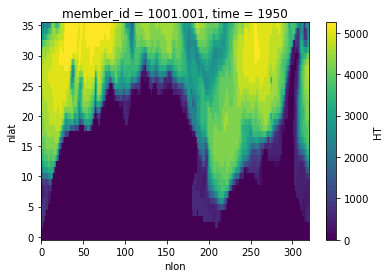

In [31]:
# keep the bottom depth because we need to mask by the continental shelf
# all members and years have the same field here, so just grab member 1, time 1
depth = ds_in.HT.isel(time=0,member_id=0)
# convert to meters from cm
depth = depth/100.0

depth.plot()

In [32]:
# keep the variable of interest only
tbot = ds_in.TEMP_bottom

# mask temperature to be continental shelf only (tried both 2000m and 3000m - little difference)
tbot_mask = tbot.where(depth <=3000.0)

In [33]:
# calculate regional average

# multiply data by tarea and regions to get just regions of interest in each variable
tbot_regions = tbot_mask * region_masks * tarea

# calculate area weighted averages of each variable for each region
tbot_avg = tbot_regions.sum(dim=['nlat','nlon'])/tarea_region.sum(dim=['nlat','nlon'])

### Load the NPP data

In [34]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [35]:
# Read in cesm2-le  data
file_in = 'CESM2-LE-seasonal-integrals-NPP.nc'
ds_in = xr.open_mfdataset(dir_in+file_in,decode_times=False)

ds_in

# reassign nlat and nlon for later
ds_in['nlat'] = ds_grid.nlat
ds_in['nlon'] = ds_grid.nlon

In [36]:
# keep the variable of interest only
npp = ds_in.NPP_ONDJFM

In [37]:
# calculate regional average

# multiply data by tarea and regions to get just regions of interest in each variable
npp_regions = npp * region_masks * tarea

# calculate area weighted averages of each variable for each region
npp_avg = npp_regions.sum(dim=['nlat','nlon'])/tarea_region.sum(dim=['nlat','nlon'])

### Load the KGP data

In [38]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [39]:
# Read in cesm2-le  data
file_in = 'CESM2-LE-seasonal-integrals-KGP.nc'
ds_in = xr.open_mfdataset(dir_in+file_in,decode_times=False)

ds_in

# reassign nlat and nlon for later
ds_in['nlat'] = ds_grid.nlat
ds_in['nlon'] = ds_grid.nlon

In [40]:
# keep the variable of interest only
kgp = ds_in.KGP_ONDJFM

In [41]:
# mask the KGP data 

# mask negative KGP --> Negative KGP means they die
kgp = kgp.where(kgp > 0.0)

# mask where temperatures are too high
# Krill are stenothermic and can't live in areas with SST >3C
kgp = kgp.where(sst < 3.0)

In [42]:
# calculate regional average

# multiply data by tarea and regions to get just regions of interest in each variable
kgp_regions = kgp * region_masks * tarea

# calculate area weighted averages of each variable for each region
kgp_avg = kgp_regions.sum(dim=['nlat','nlon'])/tarea_region.sum(dim=['nlat','nlon'])

### Load the FEISTY data

In [43]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [44]:
# Read in cesm2-le  data
file_in = 'CESM2-LE-annual-mean-FEISTY.nc'
ds_in = xr.open_mfdataset(dir_in+file_in,decode_times=False)

ds_in

# reassign nlat and nlon for later
ds_in['nlat'] = ds_grid.nlat
ds_in['nlon'] = ds_grid.nlon

In [45]:
# keep the variable of interest only
dfb = ds_in.Demersal

In [46]:
# mask the demersal fish data 

# mask where temperatures are too high
# Toothfish live in habitat with bottom temperatures <1C
# use Tbot JUST on continental shelf

dfb = dfb.where(tbot_mask < 1.0)

In [47]:
# calculate regional average

# multiply data by tarea and regions to get just regions of interest in each variable
dfb_regions = dfb * region_masks * tarea

# calculate area weighted averages of each variable for each region
dfb_avg = dfb_regions.sum(dim=['nlat','nlon'])/tarea_region.sum(dim=['nlat','nlon'])

### Load the Emperor Penguin data

- Note that we do not have to calculate regional means because the projection is for the region
- We have to load three files for the 2.5, 50 (median), and 97.5 percentile projections

In [118]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

In [119]:
# these population projections are for years 1900-2100
years = np.arange(1900,2101,1)
tlen = len(years)
print(tlen)

201


In [120]:
# load future Emperor Penguin population projections

# 2.5 percentile
file_in = 'Emperor_region_future_projections_02.5per_CMR.csv'
data_025 = pd.read_csv(dir_in + file_in)

# 50 percentile (median)
file_in = 'Emperor_region_future_projections_50.0per_CMR.csv'
data_500 = pd.read_csv(dir_in + file_in)

# 97.5 percentile
file_in = 'Emperor_region_future_projections_97.5per_CMR.csv'
data_975 = pd.read_csv(dir_in + file_in)

In [121]:
data_025

,WS1,WS2,EA1,EA2,EA3,EA4,DUR,RSR,AMD,AP
0,85113.00,8.665600e+03,6740.100000,6244.000000,5253.400000,18237.000000,7961.200000,64157.00,5920.400,4534.2000
1,82744.00,3.018200e+03,4602.700000,4576.500000,3860.400000,15931.000000,6620.900000,59260.00,3161.200,2609.3000
2,80594.00,3.269900e+03,3665.900000,4061.600000,3352.800000,15070.000000,6386.100000,56445.00,2509.600,1922.5000
3,79782.00,2.776500e+03,3318.100000,3902.000000,3218.300000,14743.000000,6282.300000,53832.00,2079.900,1560.8000
4,79653.00,2.829000e+03,3026.600000,3764.100000,3133.400000,14391.000000,6392.400000,51954.00,1786.100,1424.7000
...,...,...,...,...,...,...,...,...,...,...
196,1018.00,2.550000e-10,0.003627,0.005091,0.002310,0.015397,0.253730,1295.90,20.657,9.8028
197,897.73,1.340000e-10,0.002221,0.002920,0.001217,0.008901,0.183150,1104.10,17.419,7.7288
198,791.28,4.030000e-11,0.001354,0.001710,0.000623,0.005162,0.125230,973.08,19.519,8.8853
199,691.22,2.380000e-11,0.000793,0.000922,0.000352,0.002884,0.079325,869.88,14.227,5.8982


In [122]:
# save list of region IDs (these correspond to map)
regions = list(data_500)

In [123]:
# convert future data to xarray and assign metadata
data_025 = xr.DataArray(data_025,dims=('time','regions'))
data_025['time'] = years
data_025['regions'] = regions

data_500 = xr.DataArray(data_500,dims=('time','regions'))
data_500['time'] = years
data_500['regions'] = regions

data_975 = xr.DataArray(data_975,dims=('time','regions'))
data_975['time'] = years
data_975['regions'] = regions

In [124]:
# combine into one array
# percentiles - 2.5, 50.0 (median), 97.5
ep_data = xr.concat([data_025, data_500, data_975], dim = 'percentile')

In [183]:
# crop to match the years in other data
ep_data = ep_data.where(ep_data.time >= 1950, drop = True)
ep_data = ep_data.where(ep_data.time < 2100, drop = True)

In [184]:
# reassign time array
ep_data['time'] = npp_avg.time

In [185]:
ep_data

<xarray.DataArray (percentile: 3, time: 150, regions: 10)>
array([[[7.6142e+04, 1.8359e+03, 2.6592e+03, ..., 2.5317e+04,
         1.3853e+03, 1.0151e+03],
        [7.5776e+04, 1.7779e+03, 2.6740e+03, ..., 2.4863e+04,
         1.3916e+03, 9.9058e+02],
        [7.5264e+04, 1.7976e+03, 2.6884e+03, ..., 2.5283e+04,
         1.3667e+03, 1.0323e+03],
        ...,
        [8.9773e+02, 1.3400e-10, 2.2210e-03, ..., 1.1041e+03,
         1.7419e+01, 7.7288e+00],
        [7.9128e+02, 4.0300e-11, 1.3541e-03, ..., 9.7308e+02,
         1.9519e+01, 8.8853e+00],
        [6.9122e+02, 2.3800e-11, 7.9277e-04, ..., 8.6988e+02,
         1.4227e+01, 5.8982e+00]],

       [[1.0100e+05, 4.9270e+03, 7.3003e+03, ..., 6.4279e+04,
         4.1194e+03, 3.2333e+03],
        [1.0200e+05, 4.9343e+03, 7.3042e+03, ..., 6.4526e+04,
         4.1495e+03, 3.1969e+03],
        [1.0200e+05, 4.9134e+03, 7.3782e+03, ..., 6.4410e+04,
         4.1302e+03, 3.2348e+03],
...
        [1.2340e+04, 4.7559e-01, 3.4410e+00, ..., 2.5998e+04,
         2.1020e+02, 1.4948e+02],
        [1.1742e+04, 3.7067e-01, 2.6124e+00, ..., 2.5283e+04,
         2.1178e+02, 1.5621e+02],
        [1.0912e+04, 3.1169e-01, 1.7941e+00, ..., 2.4391e+04,
         2.0028e+02, 1.4377e+02]],

       [[1.2700e+05, 1.0714e+04, 1.4420e+04, ..., 9.4104e+04,
         1.0068e+04, 7.9786e+03],
        [1.2700e+05, 1.0700e+04, 1.4572e+04, ..., 9.4742e+04,
         1.0128e+04, 7.8710e+03],
        [1.2800e+05, 1.0611e+04, 1.4619e+04, ..., 9.5203e+04,
         1.0160e+04, 7.8666e+03],
        ...,
        [3.6205e+04, 6.3246e+00, 2.2150e+02, ..., 7.6081e+04,
         9.5868e+02, 9.3285e+02],
        [3.5037e+04, 5.5656e+00, 1.8299e+02, ..., 7.4445e+04,
         1.0154e+03, 1.0353e+03],
        [3.4017e+04, 5.0655e+00, 1.4190e+02, ..., 7.2735e+04,
         9.4567e+02, 9.3818e+02]]])
Coordinates:
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2095 2096 2097 2098 2099
  * regions  (regions) <U3 'WS1' 'WS2' 'EA1' 'EA2' ... 'DUR' 'RSR' 'AMD' 'AP'
Dimensions without coordinates: percentile

### Load the Adelie Penguin data

- Note that we do not have to calculate regional means because the projection is for the region
- We have to load three files for the 2.5, 50 (median), and 97.5 percentile projections

In [126]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

In [127]:
# these population projections are for years 1859-2100
years = np.arange(1859,2101,1)
tlen = len(years)
print(tlen)

242


In [128]:
# load future Adelie Penguin population projections

# 2.5 percentile
file_in = 'Adelie_region_future_projections_02.5per.csv'
data_025 = pd.read_csv(dir_in + file_in)

# 50 percentile (median)
file_in = 'Adelie_region_future_projections_50.0per.csv'
data_500 = pd.read_csv(dir_in + file_in)

# 97.5 percentile
file_in = 'Adelie_region_future_projections_97.5per.csv'
data_975 = pd.read_csv(dir_in + file_in)

In [129]:
data_500

,WS,EA1,EA2,EA3,EA4,DUR,RSR,AMD,AP
0,3.919151e+06,202162.5000,331548.0000,4155.250000,5.378658e+05,323021.5000,2156077.000,586780.5000,780589.30000
1,3.916743e+06,208008.4371,339165.1922,4273.765084,5.526865e+05,329352.1734,2169905.437,582071.5414,746395.68060
2,3.882161e+06,213992.9554,344756.3067,4368.307594,5.625031e+05,337523.0986,2160654.658,582172.3900,702888.31810
3,3.890486e+06,218629.5972,355775.5683,4343.133033,5.840382e+05,344721.2327,2189797.289,582777.8718,669726.62640
4,3.907474e+06,224050.2335,359962.4439,4600.238590,5.915319e+05,350378.7987,2201169.372,579329.8629,631462.00870
...,...,...,...,...,...,...,...,...,...
237,9.273928e+05,385798.2478,743147.2938,5531.877423,1.113698e+06,572670.3536,2899516.007,742857.6801,66378.42481
238,9.059132e+05,385843.9873,752531.7248,5394.086254,1.114813e+06,569480.9906,2883565.788,743536.9161,63124.88935
239,8.769380e+05,385213.3030,717443.5329,5198.360383,1.111646e+06,572965.7396,2905643.063,747527.7136,62354.53333
240,8.459172e+05,380431.0214,718575.1485,4923.475596,1.108879e+06,564572.8361,2896573.449,753441.0735,60098.94309


In [130]:
# save list of region IDs (these correspond to map)
regions = list(data_500)

In [131]:
# convert future data to xarray and assign metadata
data_025 = xr.DataArray(data_025,dims=('time','regions'))
data_025['time'] = years
data_025['regions'] = regions

data_500 = xr.DataArray(data_500,dims=('time','regions'))
data_500['time'] = years
data_500['regions'] = regions

data_975 = xr.DataArray(data_975,dims=('time','regions'))
data_975['time'] = years
data_975['regions'] = regions

In [132]:
# combine into one array
# percentiles - 2.5, 50.0 (median), 97.5
ap_data = xr.concat([data_025, data_500, data_975], dim = 'percentile')

In [179]:
# crop to match the years in other data
ap_data = ap_data.where(ap_data.time >= 1950, drop = True)
ap_data = ap_data.where(ap_data.time < 2100, drop = True)

In [181]:
# reassign time array
ap_data['time'] = npp_avg.time

In [182]:
ap_data

<xarray.DataArray (percentile: 3, time: 150, regions: 9)>
array([[[1.56710648e+06, 1.76411068e+05, 3.17754652e+05, ...,
         7.77087361e+05, 5.68707539e+04, 4.77139363e+04],
        [1.59793045e+06, 1.80100111e+05, 3.22211602e+05, ...,
         7.76875298e+05, 5.33064262e+04, 4.28162137e+04],
        [1.60428244e+06, 1.75637599e+05, 3.26530857e+05, ...,
         7.69088725e+05, 5.23118792e+04, 4.13724502e+04],
        ...,
        [1.31831997e+05, 1.31358973e+05, 2.06252472e+05, ...,
         6.98661555e+05, 5.72537579e+04, 7.01673420e+03],
        [1.28462099e+05, 1.30153407e+05, 2.07902967e+05, ...,
         6.99361807e+05, 5.56639321e+04, 6.99771540e+03],
        [1.20632696e+05, 1.32650537e+05, 2.18008292e+05, ...,
         6.88489770e+05, 5.88758645e+04, 6.76725530e+03]],

       [[3.85660679e+06, 4.65604829e+05, 6.99716113e+05, ...,
         2.43600522e+06, 4.37945646e+05, 1.60185980e+05],
        [3.82240282e+06, 4.61248649e+05, 6.82959040e+05, ...,
         2.45023094e+06, 4.41065387e+05, 1.63707736e+05],
        [3.90126973e+06, 4.63610141e+05, 6.89805032e+05, ...,
         2.47344833e+06, 4.35909520e+05, 1.59754191e+05],
...
        [9.05913228e+05, 3.85843987e+05, 7.52531725e+05, ...,
         2.88356579e+06, 7.43536916e+05, 6.31248893e+04],
        [8.76937955e+05, 3.85213303e+05, 7.17443533e+05, ...,
         2.90564306e+06, 7.47527714e+05, 6.23545333e+04],
        [8.45917203e+05, 3.80431021e+05, 7.18575149e+05, ...,
         2.89657345e+06, 7.53441074e+05, 6.00989431e+04]],

       [[9.06705133e+06, 6.27033748e+05, 1.09068489e+06, ...,
         4.91866721e+06, 1.23951066e+06, 4.65397946e+05],
        [9.09016974e+06, 6.24804195e+05, 1.09823727e+06, ...,
         4.80288617e+06, 1.27479148e+06, 4.67889306e+05],
        [9.03748030e+06, 6.26847024e+05, 1.12576035e+06, ...,
         4.78397947e+06, 1.22921562e+06, 4.59395984e+05],
        ...,
        [3.62379346e+06, 6.50480665e+05, 1.20983907e+06, ...,
         5.32797060e+06, 1.59755087e+06, 2.04326893e+05],
        [3.48677613e+06, 6.26214226e+05, 1.17089372e+06, ...,
         5.33249584e+06, 1.52939836e+06, 1.98325888e+05],
        [3.47571775e+06, 6.40582871e+05, 1.16760416e+06, ...,
         5.36116565e+06, 1.56789896e+06, 2.05787757e+05]]])
Coordinates:
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2095 2096 2097 2098 2099
  * regions  (regions) <U3 'WS' 'EA1' 'EA2' 'EA3' 'EA4' 'DUR' 'RSR' 'AMD' 'AP'
Dimensions without coordinates: percentile

### Figure out Penguin region names

keep only regions of interest and rename them to other names
- Region list from grid file has these regions: ['Weddell', 'Prydz', 'DUrville', 'Ross', 'Amundsen', 'Peninsula']
- These correspond to the following regions in the Emperor penguin file: ['WS1','EA4','DUR','RSR','AMD','AP']
- These correspond to the following regions in the Adelie penguin file: ['WS','EA4','DUR','RSR','AMD','AP']. No penguin colonies in WS-2, so not in that file. Just WS.

![Regions.png](Regions.png)

In [186]:
# make region_list
region_list = ['Weddell', 'Prydz', 'DUrville', 'Ross', 'Amundsen', 'Peninsula']

In [187]:
# Emperor penguins - list current regions
ep_data.regions

<xarray.DataArray 'regions' (regions: 10)>
array(['WS1', 'WS2', 'EA1', 'EA2', 'EA3', 'EA4', 'DUR', 'RSR', 'AMD', 'AP'],
      dtype='<U3')
Coordinates:
  * regions  (regions) <U3 'WS1' 'WS2' 'EA1' 'EA2' ... 'DUR' 'RSR' 'AMD' 'AP'

In [188]:
# Emperor penguins - put data to keep into one xarray datset that matches other variables
ep_region = xr.concat([ep_data.sel(regions='WS1'), ep_data.sel(regions='EA4'), ep_data.sel(regions='DUR'),
                       ep_data.sel(regions='RSR'), ep_data.sel(regions='AMD'), ep_data.sel(regions='AP')],
                         dim='region')
ep_region['region'] = region_list

In [189]:
# Adelie penguins - list current regions
ap_data.regions

<xarray.DataArray 'regions' (regions: 9)>
array(['WS', 'EA1', 'EA2', 'EA3', 'EA4', 'DUR', 'RSR', 'AMD', 'AP'],
      dtype='<U3')
Coordinates:
  * regions  (regions) <U3 'WS' 'EA1' 'EA2' 'EA3' 'EA4' 'DUR' 'RSR' 'AMD' 'AP'

In [190]:
# Adelie penguins - put data to keep into one xarray datset that matches other variables
ap_region = xr.concat([ap_data.sel(regions='WS'), ap_data.sel(regions='EA4'), ap_data.sel(regions='DUR'),
                       ap_data.sel(regions='RSR'), ap_data.sel(regions='AMD'), ap_data.sel(regions='AP')],
                         dim='region')
ap_region['region'] = region_list

## Calculate decadal averages
- Average over both years and ensemble members to get decadal values
- Calculate both mean AND standard deviation

In [148]:
# specify some arrays that will become coordinate arrays
decades = list(range(1960,2100,10))
decade_names = ['1960','1970','1980','1990','2000','2010','2020','2030','2040','2050','2060','2070','2080','2090']

In [149]:
# get dimensions of the grid we need to iterate over
xlen = len(ds_in.nlon)
ylen = len(ds_in.nlat)
dlen = len(decades)
rlen = len(region_masks.region)
print(xlen,ylen,dlen,rlen)

320 36 14 6


In [150]:
# Loop through decades - SIC
# for SIC reassign time dimension to match other data or this loop won't work
sic_avg['time'] = sst_avg.time

print('SIC')
data_in = sic_avg

# make numpy array to fill and specify dimensions
array_avg = np.zeros([dlen,rlen])
array_std = np.zeros([dlen,rlen])

for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 1960:
        count = 0
    else: 
        count = count+1    
    # set the start and end years for this decade
    yy_st = dec - 2
    yy_ed = dec +3
    yy = list(range(yy_st,yy_ed,1)) 
    # get data subset of area weighted averages
    temp1 = data_in.where((data_in.time >= yy_st)&(data_in.time < yy_ed),drop=True)
    # calculate mean over years and ensemble members
    array_avg[count,:] = temp1.mean(dim=['time','member_id'])
    # calculate standard deviation over years and ensemble members
    array_std[count,:] = temp1.std(dim=['time','member_id'])

# convert to xarray
data_dec_avg = xr.DataArray(array_avg,dims=('decades','region'))
data_dec_avg['decades'] = decades
data_dec_avg['region'] = region_masks.region

data_dec_std = xr.DataArray(array_std,dims=('decades','region'))
data_dec_std['decades'] = decades
data_dec_std['region'] = region_masks.region

# assign data
sic_dec_avg = data_dec_avg
sic_dec_std = data_dec_std

SIC
Calculating decadal means for 1960s
Calculating decadal means for 1970s
Calculating decadal means for 1980s
Calculating decadal means for 1990s
Calculating decadal means for 2000s
Calculating decadal means for 2010s
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


In [151]:
# Loop through decades - SST
print('SST')
data_in = sst_avg

# make numpy array to fill and specify dimensions
array_avg = np.zeros([dlen,rlen])
array_std = np.zeros([dlen,rlen])

for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 1960:
        count = 0
    else: 
        count = count+1    
    # set the start and end years for this decade
    yy_st = dec - 2
    yy_ed = dec +3
    yy = list(range(yy_st,yy_ed,1)) 
    # get data subset of area weighted averages
    temp1 = data_in.where((data_in.time >= yy_st)&(data_in.time < yy_ed),drop=True)
    # calculate mean over years and ensemble members
    array_avg[count,:] = temp1.mean(dim=['time','member_id'])
    # calculate standard deviation over years and ensemble members
    array_std[count,:] = temp1.std(dim=['time','member_id'])

# convert to xarray
data_dec_avg = xr.DataArray(array_avg,dims=('decades','region'))
data_dec_avg['decades'] = decades
data_dec_avg['region'] = region_masks.region

data_dec_std = xr.DataArray(array_std,dims=('decades','region'))
data_dec_std['decades'] = decades
data_dec_std['region'] = region_masks.region

# assign data
sst_dec_avg = data_dec_avg
sst_dec_std = data_dec_std

SST
Calculating decadal means for 1960s
Calculating decadal means for 1970s
Calculating decadal means for 1980s
Calculating decadal means for 1990s
Calculating decadal means for 2000s
Calculating decadal means for 2010s
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


In [152]:
# Loop through decades - TBOT
print('TBOT')
data_in = tbot_avg

# make numpy array to fill and specify dimensions
array_avg = np.zeros([dlen,rlen])
array_std = np.zeros([dlen,rlen])

for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 1960:
        count = 0
    else: 
        count = count+1    
    # set the start and end years for this decade
    yy_st = dec - 2
    yy_ed = dec +3
    yy = list(range(yy_st,yy_ed,1)) 
    # get data subset of area weighted averages
    temp1 = data_in.where((data_in.time >= yy_st)&(data_in.time < yy_ed),drop=True)
    # calculate mean over years and ensemble members
    array_avg[count,:] = temp1.mean(dim=['time','member_id'])
    # calculate standard deviation over years and ensemble members
    array_std[count,:] = temp1.std(dim=['time','member_id'])

# convert to xarray
data_dec_avg = xr.DataArray(array_avg,dims=('decades','region'))
data_dec_avg['decades'] = decades
data_dec_avg['region'] = region_masks.region

data_dec_std = xr.DataArray(array_std,dims=('decades','region'))
data_dec_std['decades'] = decades
data_dec_std['region'] = region_masks.region

# assign data
tbot_dec_avg = data_dec_avg
tbot_dec_std = data_dec_std

TBOT
Calculating decadal means for 1960s
Calculating decadal means for 1970s
Calculating decadal means for 1980s
Calculating decadal means for 1990s
Calculating decadal means for 2000s
Calculating decadal means for 2010s
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


In [153]:
# Loop through decades - NPP
print('NPP')
data_in = npp_avg

# make numpy array to fill and specify dimensions
array_avg = np.zeros([dlen,rlen])
array_std = np.zeros([dlen,rlen])

for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 1960:
        count = 0
    else: 
        count = count+1    
    # set the start and end years for this decade
    yy_st = dec - 2
    yy_ed = dec +3
    yy = list(range(yy_st,yy_ed,1)) 
    # get data subset of area weighted averages
    temp1 = data_in.where((data_in.time >= yy_st)&(data_in.time < yy_ed),drop=True)
    # calculate mean over years and ensemble members
    array_avg[count,:] = temp1.mean(dim=['time','member_id'])
    # calculate standard deviation over years and ensemble members
    array_std[count,:] = temp1.std(dim=['time','member_id'])

# convert to xarray
data_dec_avg = xr.DataArray(array_avg,dims=('decades','region'))
data_dec_avg['decades'] = decades
data_dec_avg['region'] = region_masks.region

data_dec_std = xr.DataArray(array_std,dims=('decades','region'))
data_dec_std['decades'] = decades
data_dec_std['region'] = region_masks.region

# assign data
npp_dec_avg = data_dec_avg
npp_dec_std = data_dec_std

NPP
Calculating decadal means for 1960s
Calculating decadal means for 1970s
Calculating decadal means for 1980s
Calculating decadal means for 1990s
Calculating decadal means for 2000s
Calculating decadal means for 2010s
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


In [154]:
# Loop through decades - KGP
print('KGP')
data_in = kgp_avg

# make numpy array to fill and specify dimensions
array_avg = np.zeros([dlen,rlen])
array_std = np.zeros([dlen,rlen])

for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 1960:
        count = 0
    else: 
        count = count+1    
    # set the start and end years for this decade
    yy_st = dec - 2
    yy_ed = dec +3
    yy = list(range(yy_st,yy_ed,1)) 
    # get data subset of area weighted averages
    temp1 = data_in.where((data_in.time >= yy_st)&(data_in.time < yy_ed),drop=True)
    # calculate mean over years and ensemble members
    array_avg[count,:] = temp1.mean(dim=['time','member_id'])
    # calculate standard deviation over years and ensemble members
    array_std[count,:] = temp1.std(dim=['time','member_id'])

# convert to xarray
data_dec_avg = xr.DataArray(array_avg,dims=('decades','region'))
data_dec_avg['decades'] = decades
data_dec_avg['region'] = region_masks.region

data_dec_std = xr.DataArray(array_std,dims=('decades','region'))
data_dec_std['decades'] = decades
data_dec_std['region'] = region_masks.region

# assign data
kgp_dec_avg = data_dec_avg
kgp_dec_std = data_dec_std

KGP
Calculating decadal means for 1960s
Calculating decadal means for 1970s
Calculating decadal means for 1980s
Calculating decadal means for 1990s
Calculating decadal means for 2000s
Calculating decadal means for 2010s
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


In [155]:
# Loop through decades - DFB
print('DFB')
data_in = dfb_avg

# make numpy array to fill and specify dimensions
array_avg = np.zeros([dlen,rlen])
array_std = np.zeros([dlen,rlen])

for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 1960:
        count = 0
    else: 
        count = count+1    
    # set the start and end years for this decade
    yy_st = dec - 2
    yy_ed = dec +3
    yy = list(range(yy_st,yy_ed,1)) 
    # get data subset of area weighted averages
    temp1 = data_in.where((data_in.time >= yy_st)&(data_in.time < yy_ed),drop=True)
    # calculate mean over years and ensemble members
    array_avg[count,:] = temp1.mean(dim=['time','member_id'])
    # calculate standard deviation over years and ensemble members
    array_std[count,:] = temp1.std(dim=['time','member_id'])

# convert to xarray
data_dec_avg = xr.DataArray(array_avg,dims=('decades','region'))
data_dec_avg['decades'] = decades
data_dec_avg['region'] = region_masks.region

data_dec_std = xr.DataArray(array_std,dims=('decades','region'))
data_dec_std['decades'] = decades
data_dec_std['region'] = region_masks.region

# assign data
dfb_dec_avg = data_dec_avg
dfb_dec_std = data_dec_std

DFB
Calculating decadal means for 1960s
Calculating decadal means for 1970s
Calculating decadal means for 1980s
Calculating decadal means for 1990s
Calculating decadal means for 2000s
Calculating decadal means for 2010s
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


In [199]:
# Loop through decades - EP
# have to include percentiles but we don't have ensemble members, so don't average over that
print('EP')
data_in = ep_region

# find length of percentiles for numpy array
plen = len(ep_region.percentile)

# make numpy array to fill and specify dimensions
array_avg = np.zeros([dlen,rlen,plen])

for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 1960:
        count = 0
    else: 
        count = count+1    
    # set the start and end years for this decade
    yy_st = dec - 2
    yy_ed = dec +3
    yy = list(range(yy_st,yy_ed,1)) 
    # get data subset of area weighted averages
    temp1 = data_in.where((data_in.time >= yy_st)&(data_in.time < yy_ed),drop=True)
    # calculate mean over years and ensemble members
    array_avg[count,:,:] = temp1.mean(dim=['time'])

# convert to xarray
data_dec_avg = xr.DataArray(array_avg,dims=('decades','region','percentile'))
data_dec_avg['decades'] = decades
data_dec_avg['region'] = region_masks.region

# assign data
ep_dec_avg = data_dec_avg

EP
Calculating decadal means for 1960s
Calculating decadal means for 1970s
Calculating decadal means for 1980s
Calculating decadal means for 1990s
Calculating decadal means for 2000s
Calculating decadal means for 2010s
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


In [201]:
# Loop through decades - AP
# have to include percentiles but we don't have ensemble members, so don't average over that
print('AP')
data_in = ap_region

# find length of percentiles for numpy array
plen = len(ep_region.percentile)

# make numpy array to fill and specify dimensions
array_avg = np.zeros([dlen,rlen,plen])

for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 1960:
        count = 0
    else: 
        count = count+1    
    # set the start and end years for this decade
    yy_st = dec - 2
    yy_ed = dec +3
    yy = list(range(yy_st,yy_ed,1)) 
    # get data subset of area weighted averages
    temp1 = data_in.where((data_in.time >= yy_st)&(data_in.time < yy_ed),drop=True)
    # calculate mean over years and ensemble members
    array_avg[count,:,:] = temp1.mean(dim=['time'])

# convert to xarray
data_dec_avg = xr.DataArray(array_avg,dims=('decades','region','percentile'))
data_dec_avg['decades'] = decades
data_dec_avg['region'] = region_masks.region

# assign data
ap_dec_avg = data_dec_avg

AP
Calculating decadal means for 1960s
Calculating decadal means for 1970s
Calculating decadal means for 1980s
Calculating decadal means for 1990s
Calculating decadal means for 2000s
Calculating decadal means for 2010s
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


## Plot figures

- Plot regional timeseries by decade for EACH region

In [290]:
# Set plotting info

# array against which to plot
xarr_dec = decades
xticks = [1960,1980,2000,2020,2040,2060,2080]
xstr = ['1960','1980','2000','2020','2040','2060','2080']

#Get plotting info by region
region_names = ['Weddell','Prydz','DUrville','Ross','Amundsen','Peninsula']
colors = ['skyblue','orange','gold','firebrick','lightcoral','darkblue']

In [291]:
# set line and marker info
ls = '-'
lw = 3
elw = 1.5
mm = 'o'
ms = '7'
fs = 12

In [306]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_6/'

### Plot each region separately

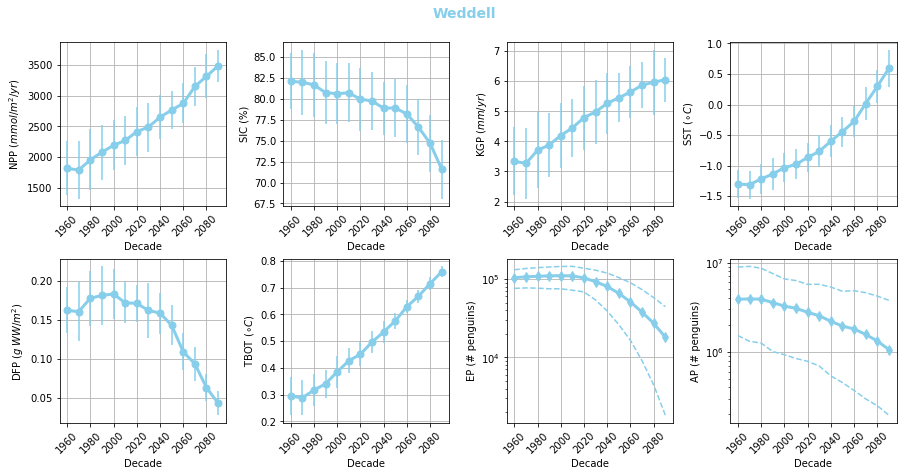

In [315]:
# create figure
fig = plt.figure(figsize=(15,7))
# set which region we're plotting
n = 0
reg = region_names[n]
cc =  colors[n] #'black'
fout = 'Figure_7_regional_timeseries_'+reg

# Make subplots
# set plot spacing for the figure to include colorbars
gs = gridspec.GridSpec(nrows=3, ncols=7, height_ratios=(1,0.05,1), width_ratios=(1, 0.1, 1, 0.1, 1, 0.1,1))

# set all the different plot items
ax_ts1 = plt.subplot(gs[0, 0])
ax_ts2 = plt.subplot(gs[0, 2])
ax_ts3 = plt.subplot(gs[0, 4])
ax_ts4 = plt.subplot(gs[0, 6])
ax_ts5 = plt.subplot(gs[2, 0])
ax_ts6 = plt.subplot(gs[2, 2])
ax_ts7 = plt.subplot(gs[2, 4])
ax_ts8 = plt.subplot(gs[2, 6])

### first variable - NPP
ax_ts1.errorbar(xarr_dec,npp_dec_avg.sel(region=reg),yerr=npp_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
ax_ts1.set_ylabel(r'NPP ($mmol/m^2/yr$)')
ax_ts1.set_xlabel('Decade')
ax_ts1.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts1.grid()

### second variable - SIC
ax_ts2.errorbar(xarr_dec,sic_dec_avg.sel(region=reg),yerr=sic_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling
ax_ts2.set_ylabel(r'SIC (%)')
ax_ts2.set_xlabel('Decade')
ax_ts2.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts2.grid()

### third variable - KGP
ax_ts3.errorbar(xarr_dec,kgp_dec_avg.sel(region=reg),yerr=kgp_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
ax_ts3.set_ylabel(r'KGP ($mm/yr$)')
ax_ts3.set_xlabel('Decade')
ax_ts3.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts3.grid()

### fourth variable - SST
ax_ts4.errorbar(xarr_dec,sst_dec_avg.sel(region=reg),yerr=sst_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling
ax_ts4.set_ylabel(r'SST ($\circ C$)')
ax_ts4.set_xlabel('Decade')
ax_ts4.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts4.grid()

### fifth variable - DFB
ax_ts5.errorbar(xarr_dec,dfb_dec_avg.sel(region=reg),yerr=dfb_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling 
ax_ts5.set_ylabel(r'DFP ($g \; WW/m^2$)')
ax_ts5.set_xlabel('Decade')
ax_ts5.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts5.grid()

### sixth variable - TBOT
ax_ts6.errorbar(xarr_dec,tbot_dec_avg.sel(region=reg),yerr=tbot_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling
ax_ts6.set_ylabel(r'TBOT ($\circ C$)')
ax_ts6.set_xlabel('Decade')
ax_ts6.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts6.grid()

### seventh variable - EP
ax_ts7.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=1),color=cc,linestyle=ls,linewidth=lw,marker='d',markersize=ms)
ax_ts7.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=0),color=cc,linestyle='dashed',linewidth=lw/2)
ax_ts7.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=2),color=cc,linestyle='dashed',linewidth=lw/2)
# labeling    
ax_ts7.set_ylabel(r'EP (# penguins)')
ax_ts7.set_yscale('log')
ax_ts7.set_xlabel('Decade')
ax_ts7.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts7.grid()

### eighth variable - AP
ax_ts8.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=1),color=cc,linestyle=ls,linewidth=lw,marker='d',markersize=ms)
ax_ts8.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=0),color=cc,linestyle='dashed',linewidth=lw/2)
ax_ts8.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=2),color=cc,linestyle='dashed',linewidth=lw/2)
# labeling 
ax_ts8.set_ylabel(r'AP (# penguins)')
ax_ts8.set_yscale('log')
ax_ts8.set_xlabel('Decade')
ax_ts8.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts8.grid()

# Finalize figure and save
fig = plt.suptitle(reg,fontsize=14,y=0.95,color=cc,fontweight='bold')
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

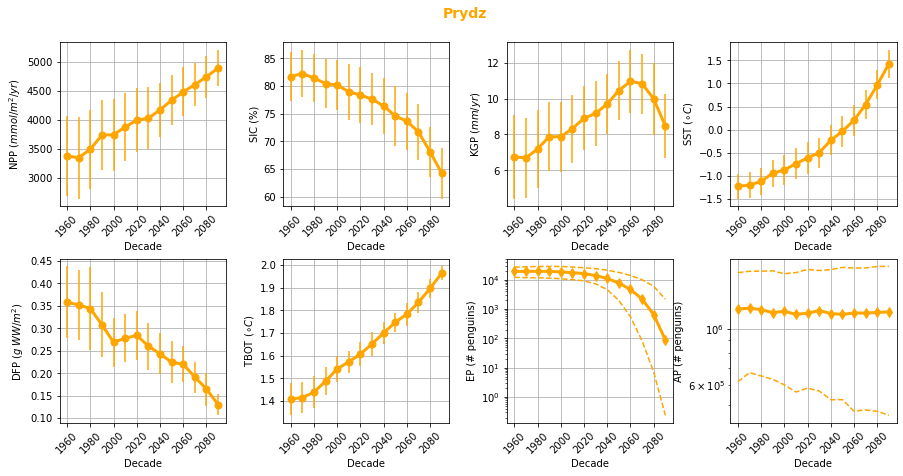

In [316]:
# create figure
fig = plt.figure(figsize=(15,7))
# set which region we're plotting
n = 1
reg = region_names[n]
cc =  colors[n] #'black'
fout = 'Figure_7_regional_timeseries_'+reg

# Make subplots
# set plot spacing for the figure to include colorbars
gs = gridspec.GridSpec(nrows=3, ncols=7, height_ratios=(1,0.05,1), width_ratios=(1, 0.1, 1, 0.1, 1, 0.1,1))

# set all the different plot items
ax_ts1 = plt.subplot(gs[0, 0])
ax_ts2 = plt.subplot(gs[0, 2])
ax_ts3 = plt.subplot(gs[0, 4])
ax_ts4 = plt.subplot(gs[0, 6])
ax_ts5 = plt.subplot(gs[2, 0])
ax_ts6 = plt.subplot(gs[2, 2])
ax_ts7 = plt.subplot(gs[2, 4])
ax_ts8 = plt.subplot(gs[2, 6])

### first variable - NPP
ax_ts1.errorbar(xarr_dec,npp_dec_avg.sel(region=reg),yerr=npp_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
ax_ts1.set_ylabel(r'NPP ($mmol/m^2/yr$)')
ax_ts1.set_xlabel('Decade')
ax_ts1.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts1.grid()

### second variable - SIC
ax_ts2.errorbar(xarr_dec,sic_dec_avg.sel(region=reg),yerr=sic_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling
ax_ts2.set_ylabel(r'SIC (%)')
ax_ts2.set_xlabel('Decade')
ax_ts2.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts2.grid()

### third variable - KGP
ax_ts3.errorbar(xarr_dec,kgp_dec_avg.sel(region=reg),yerr=kgp_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
ax_ts3.set_ylabel(r'KGP ($mm/yr$)')
ax_ts3.set_xlabel('Decade')
ax_ts3.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts3.grid()

### fourth variable - SST
ax_ts4.errorbar(xarr_dec,sst_dec_avg.sel(region=reg),yerr=sst_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling
ax_ts4.set_ylabel(r'SST ($\circ C$)')
ax_ts4.set_xlabel('Decade')
ax_ts4.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts4.grid()

### fifth variable - DFB
ax_ts5.errorbar(xarr_dec,dfb_dec_avg.sel(region=reg),yerr=dfb_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling 
ax_ts5.set_ylabel(r'DFP ($g \; WW/m^2$)')
ax_ts5.set_xlabel('Decade')
ax_ts5.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts5.grid()

### sixth variable - TBOT
ax_ts6.errorbar(xarr_dec,tbot_dec_avg.sel(region=reg),yerr=tbot_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling
ax_ts6.set_ylabel(r'TBOT ($\circ C$)')
ax_ts6.set_xlabel('Decade')
ax_ts6.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts6.grid()

### seventh variable - EP
ax_ts7.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=1),color=cc,linestyle=ls,linewidth=lw,marker='d',markersize=ms)
ax_ts7.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=0),color=cc,linestyle='dashed',linewidth=lw/2)
ax_ts7.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=2),color=cc,linestyle='dashed',linewidth=lw/2)
# labeling    
ax_ts7.set_ylabel(r'EP (# penguins)')
ax_ts7.set_yscale('log')
ax_ts7.set_xlabel('Decade')
ax_ts7.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts7.grid()

### eighth variable - AP
ax_ts8.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=1),color=cc,linestyle=ls,linewidth=lw,marker='d',markersize=ms)
ax_ts8.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=0),color=cc,linestyle='dashed',linewidth=lw/2)
ax_ts8.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=2),color=cc,linestyle='dashed',linewidth=lw/2)
# labeling 
ax_ts8.set_ylabel(r'AP (# penguins)')
ax_ts8.set_yscale('log')
ax_ts8.set_xlabel('Decade')
ax_ts8.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts8.grid()

# Finalize figure and save
fig = plt.suptitle(reg,fontsize=14,y=0.95,color=cc,fontweight='bold')
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

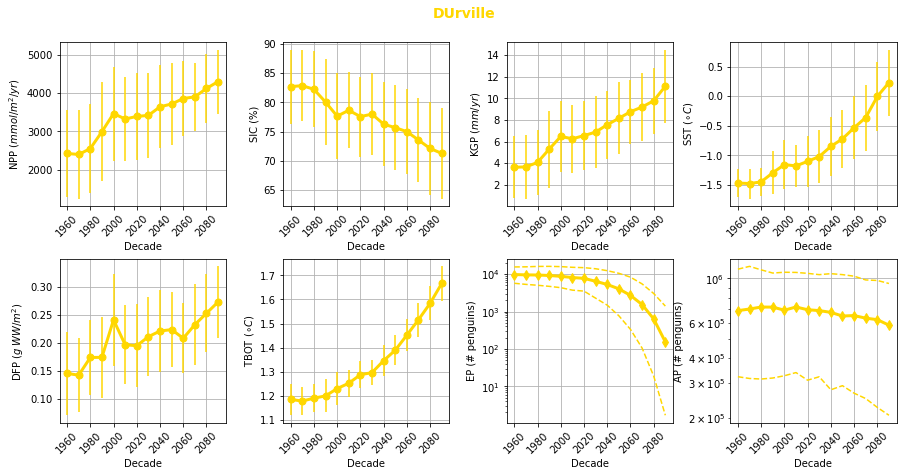

In [317]:
# create figure
fig = plt.figure(figsize=(15,7))
# set which region we're plotting
n = 2
reg = region_names[n]
cc =  colors[n] #'black'
fout = 'Figure_7_regional_timeseries_'+reg

# Make subplots
# set plot spacing for the figure to include colorbars
gs = gridspec.GridSpec(nrows=3, ncols=7, height_ratios=(1,0.05,1), width_ratios=(1, 0.1, 1, 0.1, 1, 0.1,1))

# set all the different plot items
ax_ts1 = plt.subplot(gs[0, 0])
ax_ts2 = plt.subplot(gs[0, 2])
ax_ts3 = plt.subplot(gs[0, 4])
ax_ts4 = plt.subplot(gs[0, 6])
ax_ts5 = plt.subplot(gs[2, 0])
ax_ts6 = plt.subplot(gs[2, 2])
ax_ts7 = plt.subplot(gs[2, 4])
ax_ts8 = plt.subplot(gs[2, 6])

### first variable - NPP
ax_ts1.errorbar(xarr_dec,npp_dec_avg.sel(region=reg),yerr=npp_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
ax_ts1.set_ylabel(r'NPP ($mmol/m^2/yr$)')
ax_ts1.set_xlabel('Decade')
ax_ts1.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts1.grid()

### second variable - SIC
ax_ts2.errorbar(xarr_dec,sic_dec_avg.sel(region=reg),yerr=sic_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling
ax_ts2.set_ylabel(r'SIC (%)')
ax_ts2.set_xlabel('Decade')
ax_ts2.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts2.grid()

### third variable - KGP
ax_ts3.errorbar(xarr_dec,kgp_dec_avg.sel(region=reg),yerr=kgp_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
ax_ts3.set_ylabel(r'KGP ($mm/yr$)')
ax_ts3.set_xlabel('Decade')
ax_ts3.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts3.grid()

### fourth variable - SST
ax_ts4.errorbar(xarr_dec,sst_dec_avg.sel(region=reg),yerr=sst_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling
ax_ts4.set_ylabel(r'SST ($\circ C$)')
ax_ts4.set_xlabel('Decade')
ax_ts4.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts4.grid()

### fifth variable - DFB
ax_ts5.errorbar(xarr_dec,dfb_dec_avg.sel(region=reg),yerr=dfb_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling 
ax_ts5.set_ylabel(r'DFP ($g \; WW/m^2$)')
ax_ts5.set_xlabel('Decade')
ax_ts5.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts5.grid()

### sixth variable - TBOT
ax_ts6.errorbar(xarr_dec,tbot_dec_avg.sel(region=reg),yerr=tbot_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling
ax_ts6.set_ylabel(r'TBOT ($\circ C$)')
ax_ts6.set_xlabel('Decade')
ax_ts6.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts6.grid()

### seventh variable - EP
ax_ts7.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=1),color=cc,linestyle=ls,linewidth=lw,marker='d',markersize=ms)
ax_ts7.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=0),color=cc,linestyle='dashed',linewidth=lw/2)
ax_ts7.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=2),color=cc,linestyle='dashed',linewidth=lw/2)
# labeling    
ax_ts7.set_ylabel(r'EP (# penguins)')
ax_ts7.set_yscale('log')
ax_ts7.set_xlabel('Decade')
ax_ts7.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts7.grid()

### eighth variable - AP
ax_ts8.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=1),color=cc,linestyle=ls,linewidth=lw,marker='d',markersize=ms)
ax_ts8.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=0),color=cc,linestyle='dashed',linewidth=lw/2)
ax_ts8.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=2),color=cc,linestyle='dashed',linewidth=lw/2)
# labeling 
ax_ts8.set_ylabel(r'AP (# penguins)')
ax_ts8.set_yscale('log')
ax_ts8.set_xlabel('Decade')
ax_ts8.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts8.grid()

# Finalize figure and save
fig = plt.suptitle(reg,fontsize=14,y=0.95,color=cc,fontweight='bold')
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

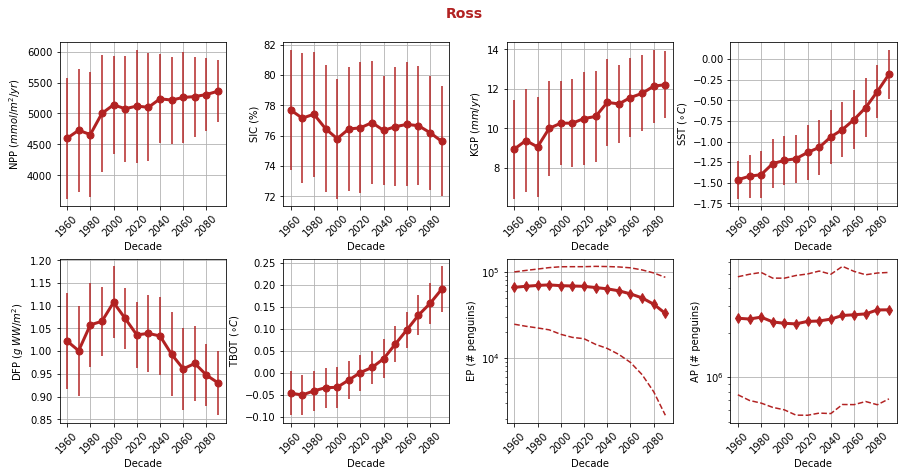

In [318]:
# create figure
fig = plt.figure(figsize=(15,7))
# set which region we're plotting
n = 3
reg = region_names[n]
cc =  colors[n] #'black'
fout = 'Figure_7_regional_timeseries_'+reg

# Make subplots
# set plot spacing for the figure to include colorbars
gs = gridspec.GridSpec(nrows=3, ncols=7, height_ratios=(1,0.05,1), width_ratios=(1, 0.1, 1, 0.1, 1, 0.1,1))

# set all the different plot items
ax_ts1 = plt.subplot(gs[0, 0])
ax_ts2 = plt.subplot(gs[0, 2])
ax_ts3 = plt.subplot(gs[0, 4])
ax_ts4 = plt.subplot(gs[0, 6])
ax_ts5 = plt.subplot(gs[2, 0])
ax_ts6 = plt.subplot(gs[2, 2])
ax_ts7 = plt.subplot(gs[2, 4])
ax_ts8 = plt.subplot(gs[2, 6])

### first variable - NPP
ax_ts1.errorbar(xarr_dec,npp_dec_avg.sel(region=reg),yerr=npp_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
ax_ts1.set_ylabel(r'NPP ($mmol/m^2/yr$)')
ax_ts1.set_xlabel('Decade')
ax_ts1.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts1.grid()

### second variable - SIC
ax_ts2.errorbar(xarr_dec,sic_dec_avg.sel(region=reg),yerr=sic_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling
ax_ts2.set_ylabel(r'SIC (%)')
ax_ts2.set_xlabel('Decade')
ax_ts2.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts2.grid()

### third variable - KGP
ax_ts3.errorbar(xarr_dec,kgp_dec_avg.sel(region=reg),yerr=kgp_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
ax_ts3.set_ylabel(r'KGP ($mm/yr$)')
ax_ts3.set_xlabel('Decade')
ax_ts3.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts3.grid()

### fourth variable - SST
ax_ts4.errorbar(xarr_dec,sst_dec_avg.sel(region=reg),yerr=sst_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling
ax_ts4.set_ylabel(r'SST ($\circ C$)')
ax_ts4.set_xlabel('Decade')
ax_ts4.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts4.grid()

### fifth variable - DFB
ax_ts5.errorbar(xarr_dec,dfb_dec_avg.sel(region=reg),yerr=dfb_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling 
ax_ts5.set_ylabel(r'DFP ($g \; WW/m^2$)')
ax_ts5.set_xlabel('Decade')
ax_ts5.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts5.grid()

### sixth variable - TBOT
ax_ts6.errorbar(xarr_dec,tbot_dec_avg.sel(region=reg),yerr=tbot_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling
ax_ts6.set_ylabel(r'TBOT ($\circ C$)')
ax_ts6.set_xlabel('Decade')
ax_ts6.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts6.grid()

### seventh variable - EP
ax_ts7.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=1),color=cc,linestyle=ls,linewidth=lw,marker='d',markersize=ms)
ax_ts7.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=0),color=cc,linestyle='dashed',linewidth=lw/2)
ax_ts7.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=2),color=cc,linestyle='dashed',linewidth=lw/2)
# labeling    
ax_ts7.set_ylabel(r'EP (# penguins)')
ax_ts7.set_yscale('log')
ax_ts7.set_xlabel('Decade')
ax_ts7.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts7.grid()

### eighth variable - AP
ax_ts8.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=1),color=cc,linestyle=ls,linewidth=lw,marker='d',markersize=ms)
ax_ts8.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=0),color=cc,linestyle='dashed',linewidth=lw/2)
ax_ts8.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=2),color=cc,linestyle='dashed',linewidth=lw/2)
# labeling 
ax_ts8.set_ylabel(r'AP (# penguins)')
ax_ts8.set_yscale('log')
ax_ts8.set_xlabel('Decade')
ax_ts8.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts8.grid()

# Finalize figure and save
fig = plt.suptitle(reg,fontsize=14,y=0.95,color=cc,fontweight='bold')
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

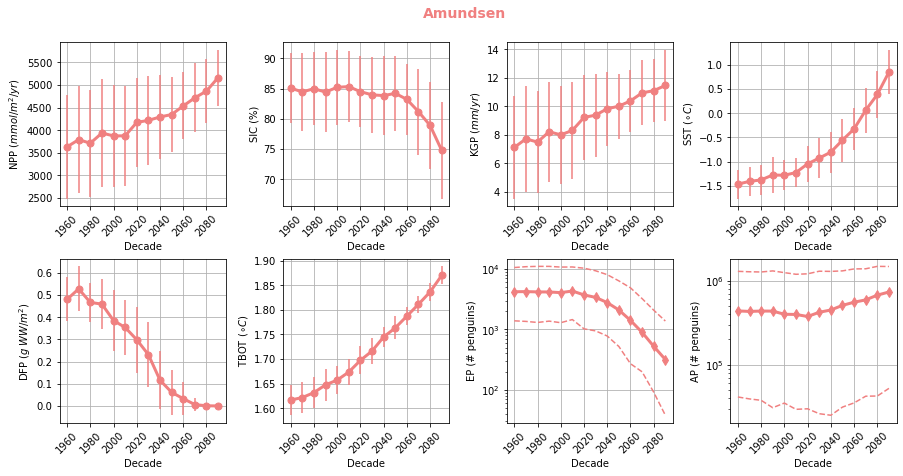

In [319]:
# create figure
fig = plt.figure(figsize=(15,7))
# set which region we're plotting
n = 4
reg = region_names[n]
cc =  colors[n] #'black'
fout = 'Figure_7_regional_timeseries_'+reg

# Make subplots
# set plot spacing for the figure to include colorbars
gs = gridspec.GridSpec(nrows=3, ncols=7, height_ratios=(1,0.05,1), width_ratios=(1, 0.1, 1, 0.1, 1, 0.1,1))

# set all the different plot items
ax_ts1 = plt.subplot(gs[0, 0])
ax_ts2 = plt.subplot(gs[0, 2])
ax_ts3 = plt.subplot(gs[0, 4])
ax_ts4 = plt.subplot(gs[0, 6])
ax_ts5 = plt.subplot(gs[2, 0])
ax_ts6 = plt.subplot(gs[2, 2])
ax_ts7 = plt.subplot(gs[2, 4])
ax_ts8 = plt.subplot(gs[2, 6])

### first variable - NPP
ax_ts1.errorbar(xarr_dec,npp_dec_avg.sel(region=reg),yerr=npp_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
ax_ts1.set_ylabel(r'NPP ($mmol/m^2/yr$)')
ax_ts1.set_xlabel('Decade')
ax_ts1.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts1.grid()

### second variable - SIC
ax_ts2.errorbar(xarr_dec,sic_dec_avg.sel(region=reg),yerr=sic_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling
ax_ts2.set_ylabel(r'SIC (%)')
ax_ts2.set_xlabel('Decade')
ax_ts2.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts2.grid()

### third variable - KGP
ax_ts3.errorbar(xarr_dec,kgp_dec_avg.sel(region=reg),yerr=kgp_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
ax_ts3.set_ylabel(r'KGP ($mm/yr$)')
ax_ts3.set_xlabel('Decade')
ax_ts3.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts3.grid()

### fourth variable - SST
ax_ts4.errorbar(xarr_dec,sst_dec_avg.sel(region=reg),yerr=sst_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling
ax_ts4.set_ylabel(r'SST ($\circ C$)')
ax_ts4.set_xlabel('Decade')
ax_ts4.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts4.grid()

### fifth variable - DFB
ax_ts5.errorbar(xarr_dec,dfb_dec_avg.sel(region=reg),yerr=dfb_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling 
ax_ts5.set_ylabel(r'DFP ($g \; WW/m^2$)')
ax_ts5.set_xlabel('Decade')
ax_ts5.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts5.grid()

### sixth variable - TBOT
ax_ts6.errorbar(xarr_dec,tbot_dec_avg.sel(region=reg),yerr=tbot_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling
ax_ts6.set_ylabel(r'TBOT ($\circ C$)')
ax_ts6.set_xlabel('Decade')
ax_ts6.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts6.grid()

### seventh variable - EP
ax_ts7.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=1),color=cc,linestyle=ls,linewidth=lw,marker='d',markersize=ms)
ax_ts7.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=0),color=cc,linestyle='dashed',linewidth=lw/2)
ax_ts7.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=2),color=cc,linestyle='dashed',linewidth=lw/2)
# labeling    
ax_ts7.set_ylabel(r'EP (# penguins)')
ax_ts7.set_yscale('log')
ax_ts7.set_xlabel('Decade')
ax_ts7.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts7.grid()

### eighth variable - AP
ax_ts8.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=1),color=cc,linestyle=ls,linewidth=lw,marker='d',markersize=ms)
ax_ts8.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=0),color=cc,linestyle='dashed',linewidth=lw/2)
ax_ts8.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=2),color=cc,linestyle='dashed',linewidth=lw/2)
# labeling 
ax_ts8.set_ylabel(r'AP (# penguins)')
ax_ts8.set_yscale('log')
ax_ts8.set_xlabel('Decade')
ax_ts8.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts8.grid()

# Finalize figure and save
fig = plt.suptitle(reg,fontsize=14,y=0.95,color=cc,fontweight='bold')
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

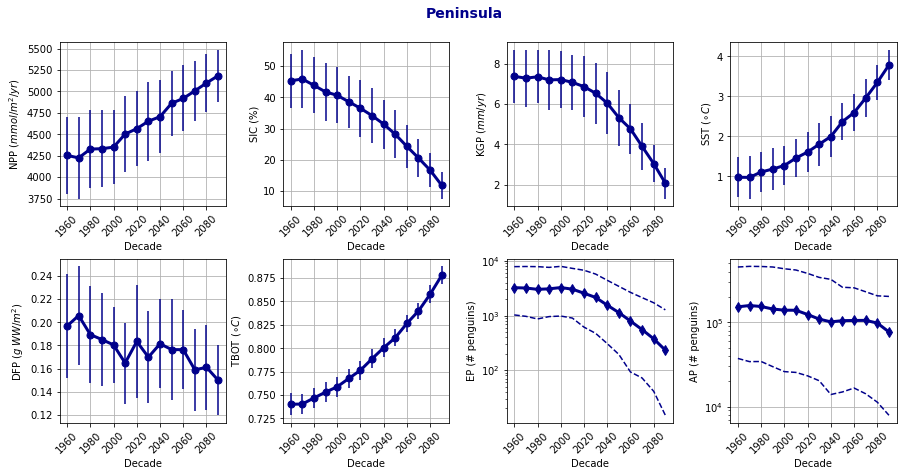

In [320]:
# create figure
fig = plt.figure(figsize=(15,7))
# set which region we're plotting
n = 5
reg = region_names[n]
cc =  colors[n] #'black'
fout = 'Figure_7_regional_timeseries_'+reg

# Make subplots
# set plot spacing for the figure to include colorbars
gs = gridspec.GridSpec(nrows=3, ncols=7, height_ratios=(1,0.05,1), width_ratios=(1, 0.1, 1, 0.1, 1, 0.1,1))

# set all the different plot items
ax_ts1 = plt.subplot(gs[0, 0])
ax_ts2 = plt.subplot(gs[0, 2])
ax_ts3 = plt.subplot(gs[0, 4])
ax_ts4 = plt.subplot(gs[0, 6])
ax_ts5 = plt.subplot(gs[2, 0])
ax_ts6 = plt.subplot(gs[2, 2])
ax_ts7 = plt.subplot(gs[2, 4])
ax_ts8 = plt.subplot(gs[2, 6])

### first variable - NPP
ax_ts1.errorbar(xarr_dec,npp_dec_avg.sel(region=reg),yerr=npp_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
ax_ts1.set_ylabel(r'NPP ($mmol/m^2/yr$)')
ax_ts1.set_xlabel('Decade')
ax_ts1.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts1.grid()

### second variable - SIC
ax_ts2.errorbar(xarr_dec,sic_dec_avg.sel(region=reg),yerr=sic_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling
ax_ts2.set_ylabel(r'SIC (%)')
ax_ts2.set_xlabel('Decade')
ax_ts2.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts2.grid()

### third variable - KGP
ax_ts3.errorbar(xarr_dec,kgp_dec_avg.sel(region=reg),yerr=kgp_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
ax_ts3.set_ylabel(r'KGP ($mm/yr$)')
ax_ts3.set_xlabel('Decade')
ax_ts3.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts3.grid()

### fourth variable - SST
ax_ts4.errorbar(xarr_dec,sst_dec_avg.sel(region=reg),yerr=sst_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling
ax_ts4.set_ylabel(r'SST ($\circ C$)')
ax_ts4.set_xlabel('Decade')
ax_ts4.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts4.grid()

### fifth variable - DFB
ax_ts5.errorbar(xarr_dec,dfb_dec_avg.sel(region=reg),yerr=dfb_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling 
ax_ts5.set_ylabel(r'DFP ($g \; WW/m^2$)')
ax_ts5.set_xlabel('Decade')
ax_ts5.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts5.grid()

### sixth variable - TBOT
ax_ts6.errorbar(xarr_dec,tbot_dec_avg.sel(region=reg),yerr=tbot_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling
ax_ts6.set_ylabel(r'TBOT ($\circ C$)')
ax_ts6.set_xlabel('Decade')
ax_ts6.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts6.grid()

### seventh variable - EP
ax_ts7.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=1),color=cc,linestyle=ls,linewidth=lw,marker='d',markersize=ms)
ax_ts7.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=0),color=cc,linestyle='dashed',linewidth=lw/2)
ax_ts7.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=2),color=cc,linestyle='dashed',linewidth=lw/2)
# labeling    
ax_ts7.set_ylabel(r'EP (# penguins)')
ax_ts7.set_yscale('log')
ax_ts7.set_xlabel('Decade')
ax_ts7.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts7.grid()

### eighth variable - AP
ax_ts8.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=1),color=cc,linestyle=ls,linewidth=lw,marker='d',markersize=ms)
ax_ts8.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=0),color=cc,linestyle='dashed',linewidth=lw/2)
ax_ts8.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=2),color=cc,linestyle='dashed',linewidth=lw/2)
# labeling 
ax_ts8.set_ylabel(r'AP (# penguins)')
ax_ts8.set_yscale('log')
ax_ts8.set_xlabel('Decade')
ax_ts8.set_xticks(xticks,labels=xstr,rotation=45.0)
ax_ts8.grid()

# Finalize figure and save
fig = plt.suptitle(reg,fontsize=14,y=0.95,color=cc,fontweight='bold')
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

## Test figures

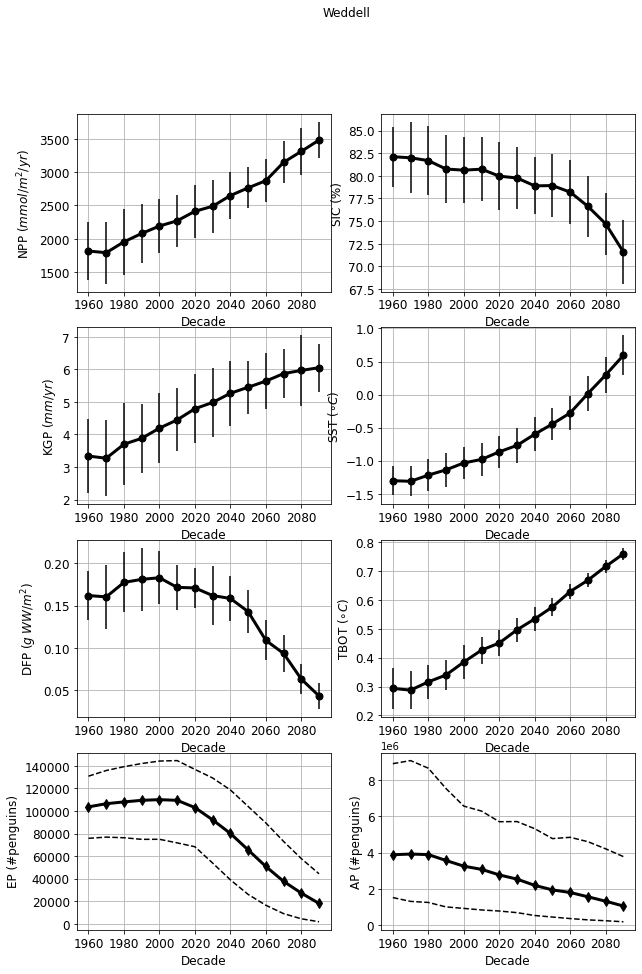

In [214]:
# create figure
fig = plt.figure(figsize=(10,15))

# set which region we're plotting
n = 0
reg = region_names[n]
cc = 'black' #colors[n]
fout = 'Figure_7_regional_timeseries_'+str(reg)

# Make subplots - note it's nrow x ncol x index (starting upper left)
### first variable - NPP
ax = fig.add_subplot(4,2,1)
ax.errorbar(xarr_dec,npp_dec_avg.sel(region=reg),yerr=npp_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
plt.xlabel('Decade',fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'NPP ($mmol/m^2/yr$)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid()

### second variable - SIC
ax = fig.add_subplot(4,2,2)
ax.errorbar(xarr_dec,sic_dec_avg.sel(region=reg),yerr=sic_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
plt.xlabel('Decade',fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'SIC (%)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid()

### third variable - KGP
ax = fig.add_subplot(4,2,3)
ax.errorbar(xarr_dec,kgp_dec_avg.sel(region=reg),yerr=kgp_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
plt.xlabel('Decade',fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'KGP ($mm/yr$)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid()

### fourth variable - SST
ax = fig.add_subplot(4,2,4)
ax.errorbar(xarr_dec,sst_dec_avg.sel(region=reg),yerr=sst_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
plt.xlabel('Decade',fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'SST ($\circ C$)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid()

### fifth variable - DFB
ax = fig.add_subplot(4,2,5)
ax.errorbar(xarr_dec,dfb_dec_avg.sel(region=reg),yerr=dfb_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
plt.xlabel('Decade',fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'DFP ($g \; WW/m^2$)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid()

### sixth variable - TBOT
ax = fig.add_subplot(4,2,6)
ax.errorbar(xarr_dec,tbot_dec_avg.sel(region=reg),yerr=tbot_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
plt.xlabel('Decade',fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'TBOT ($\circ C$)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid()

### seventh variable - EP
ax = fig.add_subplot(4,2,7)
ax.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=1),color=cc,linestyle=ls,linewidth=lw,marker='d',markersize=ms)
ax.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=0),color=cc,linestyle='dashed',linewidth=lw/2)
ax.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=2),color=cc,linestyle='dashed',linewidth=lw/2)
# labeling    
plt.xlabel('Decade',fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'EP (#penguins)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid()

### sixth variable - AP
ax = fig.add_subplot(4,2,8)
ax.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=1),color=cc,linestyle=ls,linewidth=lw,marker='d',markersize=ms)
ax.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=0),color=cc,linestyle='dashed',linewidth=lw/2)
ax.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=2),color=cc,linestyle='dashed',linewidth=lw/2)
# labeling    
plt.xlabel('Decade',fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'AP (#penguins)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid()

# Finalize figure and save
fig = plt.suptitle(str(reg.values))
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

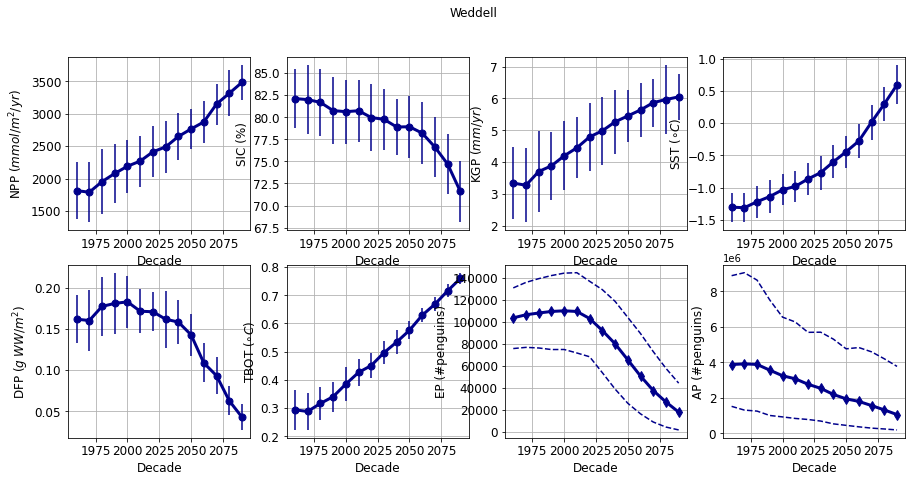

In [217]:
# create figure
fig = plt.figure(figsize=(15,7))

# set which region we're plotting
n = 0
reg = region_names[n]
cc =  colors[n] #'black'
fout = 'Figure_7_regional_timeseries_'+str(reg)

# Make subplots - note it's nrow x ncol x index (starting upper left)
### first variable - NPP
ax = fig.add_subplot(2,4,1)
ax.errorbar(xarr_dec,npp_dec_avg.sel(region=reg),yerr=npp_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
plt.xlabel('Decade',fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'NPP ($mmol/m^2/yr$)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid()

### second variable - SIC
ax = fig.add_subplot(2,4,2)
ax.errorbar(xarr_dec,sic_dec_avg.sel(region=reg),yerr=sic_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
plt.xlabel('Decade',fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'SIC (%)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid()

### third variable - KGP
ax = fig.add_subplot(2,4,3)
ax.errorbar(xarr_dec,kgp_dec_avg.sel(region=reg),yerr=kgp_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
plt.xlabel('Decade',fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'KGP ($mm/yr$)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid()

### fourth variable - SST
ax = fig.add_subplot(2,4,4)
ax.errorbar(xarr_dec,sst_dec_avg.sel(region=reg),yerr=sst_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
plt.xlabel('Decade',fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'SST ($\circ C$)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid()

### fifth variable - DFB
ax = fig.add_subplot(2,4,5)
ax.errorbar(xarr_dec,dfb_dec_avg.sel(region=reg),yerr=dfb_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
plt.xlabel('Decade',fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'DFP ($g \; WW/m^2$)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid()

### sixth variable - TBOT
ax = fig.add_subplot(2,4,6)
ax.errorbar(xarr_dec,tbot_dec_avg.sel(region=reg),yerr=tbot_dec_std.sel(region=reg),color=cc,linestyle=ls,linewidth=lw,elinewidth=elw,marker=mm,markersize=ms)
# labeling    
plt.xlabel('Decade',fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'TBOT ($\circ C$)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid()

### seventh variable - EP
ax = fig.add_subplot(2,4,7)
ax.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=1),color=cc,linestyle=ls,linewidth=lw,marker='d',markersize=ms)
ax.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=0),color=cc,linestyle='dashed',linewidth=lw/2)
ax.plot(xarr_dec,ep_dec_avg.sel(region=reg).isel(percentile=2),color=cc,linestyle='dashed',linewidth=lw/2)
# labeling    
plt.xlabel('Decade',fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'EP (#penguins)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid()

### sixth variable - AP
ax = fig.add_subplot(2,4,8)
ax.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=1),color=cc,linestyle=ls,linewidth=lw,marker='d',markersize=ms)
ax.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=0),color=cc,linestyle='dashed',linewidth=lw/2)
ax.plot(xarr_dec,ap_dec_avg.sel(region=reg).isel(percentile=2),color=cc,linestyle='dashed',linewidth=lw/2)
# labeling    
plt.xlabel('Decade',fontsize=fs)
plt.xticks(fontsize=fs)
plt.ylabel(r'AP (#penguins)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid()

# Finalize figure and save
fig = plt.suptitle(str(reg.values))
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

### By Variable plots

In [ ]:
# create figure
fig = plt.figure(figsize=(20,10))

# Make subplots - note it's nrow x ncol x index (starting upper left)
### first subplot
ax = fig.add_subplot(2,3,1)
name = 'Peninsula'
cc = 'darkblue'
# plot
ax.errorbar(decades_plt,data_avg.sel(region=name),yerr=data_std.sel(region=name),color=cc,linestyle='-',linewidth=3,elinewidth=1.5,marker='o',markersize=10)
# plot tweaks
ax.set(xlabel='Decade',ylabel=r'NPP ($mmol/m^2/yr$)')
#ax.set_ylim(1000,6500)
ax.set_title(name)
ax.grid()

### second subplot
ax = fig.add_subplot(2,3,2)
name = 'Weddell'
cc = 'skyblue'
# plot
ax.errorbar(decades_plt,data_avg.sel(region=name),yerr=data_std.sel(region=name),color=cc,linestyle='-',linewidth=3,elinewidth=1.5,marker='o',markersize=10)
# plot tweaks
ax.set(xlabel='Decade',ylabel=r'NPP ($mmol/m^2/yr$)')
#ax.set_ylim(1000,6500)
ax.set_title(name)
ax.grid()

### third subplot
ax = fig.add_subplot(2,3,3)
name = 'Prydz'
cc = 'orange'
# plot
ax.errorbar(decades_plt,data_avg.sel(region=name),yerr=data_std.sel(region=name),color=cc,linestyle='-',linewidth=3,elinewidth=1.5,marker='o',markersize=10)
# plot tweaks
ax.set(xlabel='Decade',ylabel=r'NPP ($mmol/m^2/yr$)')
#ax.set_ylim(1000,6500)
ax.set_title(name)
ax.grid()

### fourth subplot
ax = fig.add_subplot(2,3,4)
name = 'DUrville'
cc = 'gold'
# plot
ax.errorbar(decades_plt,data_avg.sel(region=name),yerr=data_std.sel(region=name),color=cc,linestyle='-',linewidth=3,elinewidth=1.5,marker='o',markersize=10)
# plot tweaks
ax.set(xlabel='Decade',ylabel=r'NPP ($mmol/m^2/yr$)')
#ax.set_ylim(1000,6500)
ax.set_title(name)
ax.grid()

### second subplot
ax = fig.add_subplot(2,3,5)
name = 'Ross'
cc = 'red'
# plot
ax.errorbar(decades_plt,data_avg.sel(region=name),yerr=data_std.sel(region=name),color=cc,linestyle='-',linewidth=3,elinewidth=1.5,marker='o',markersize=10)
# plot tweaks
ax.set(xlabel='Decade',ylabel=r'NPP ($mmol/m^2/yr$)')
#ax.set_ylim(1000,6500)
ax.set_title(name)
ax.grid()

### third subplot
ax = fig.add_subplot(2,3,6)
name = 'Amundsen'
cc = 'lightcoral'
# plot
ax.errorbar(decades_plt,data_avg.sel(region=name),yerr=data_std.sel(region=name),color=cc,linestyle='-',linewidth=3,elinewidth=1.5,marker='o',markersize=10)
# plot tweaks
ax.set(xlabel='Decade',ylabel=r'NPP ($mmol/m^2/yr$)')
#ax.set_ylim(1000,6500)
ax.set_title(name)
ax.grid()

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

In [ ]:
# create figure - % change from 1960s
fig = plt.figure(figsize=(20,10))

fout = fout+'_pct'
# calculate percent difference
top = data_avg - data_avg.sel(decades=1960)
bot = (data_avg + data_avg.sel(decades=1960))/2.0
data_diff = 100.0 * abs(top/bot)

# Make subplots - note it's nrow x ncol x index (starting upper left)
### first subplot
ax = fig.add_subplot(2,3,1)
name = 'Peninsula'
cc = 'darkblue'
# plot
ax.plot(decades_plt,data_diff.sel(region=name),color=cc,linestyle='-',linewidth=3,marker='o',markersize=10)
# plot tweaks
ax.set(xlabel='Decade',ylabel='Change from 1960 (%)')
ax.set_title(name)
ax.grid()

### second subplot
ax = fig.add_subplot(2,3,2)
name = 'Weddell'
cc = 'skyblue'
# plot
ax.plot(decades_plt,data_diff.sel(region=name),color=cc,linestyle='-',linewidth=3,marker='o',markersize=10)
# plot tweaks
ax.set(xlabel='Decade',ylabel='Change from 1960 (%)')
ax.set_title(name)
ax.grid()

### third subplot
ax = fig.add_subplot(2,3,3)
name = 'Prydz'
cc = 'orange'
# plot
ax.plot(decades_plt,data_diff.sel(region=name),color=cc,linestyle='-',linewidth=3,marker='o',markersize=10)
# plot tweaks
ax.set(xlabel='Decade',ylabel='Change from 1960 (%)')
ax.set_title(name)
ax.grid()

### fourth subplot
ax = fig.add_subplot(2,3,4)
name = 'DUrville'
cc = 'gold'
# plot
ax.plot(decades_plt,data_diff.sel(region=name),color=cc,linestyle='-',linewidth=3,marker='o',markersize=10)
# plot tweaks
ax.set(xlabel='Decade',ylabel='Change from 1960 (%)')
ax.set_title(name)
ax.grid()

### second subplot
ax = fig.add_subplot(2,3,5)
name = 'Ross'
cc = 'red'
# plot
ax.plot(decades_plt,data_diff.sel(region=name),color=cc,linestyle='-',linewidth=3,marker='o',markersize=10)
# plot tweaks
ax.set(xlabel='Decade',ylabel='Change from 1960 (%)')
ax.set_title(name)
ax.grid()

### third subplot
ax = fig.add_subplot(2,3,6)
name = 'Amundsen'
cc = 'lightcoral'
# plot
ax.plot(decades_plt,data_diff.sel(region=name),color=cc,linestyle='-',linewidth=3,marker='o',markersize=10)
# plot tweaks
ax.set(xlabel='Decade',ylabel='Change from 1960 (%)')
ax.set_title(name)
ax.grid()

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)